<center> <h2>CSCE670 Course Project: NotDot</h2> <center>
<center> <h3>Roger Solis, Qiancheng Liu, Henry Qiu, Haiping Xue</h3> <center>


<b>Introduction and Problem Statement</b>

Matrix factorization is a core method used in latent factor model-based recommendation.  While there has been much research on various improvements that can be made, one relatively unexplored area is the interaction function itself, which is traditionally the inner product. Our project follows in the footsteps of [1], which seeks to train a neural network to serve as a non-linear replacement for this interaction function.  However, [1] seeks to mimic the effects of their model on implicit data by converting any instance of a movie rating to a boolean indicating interaction between a user and item.  Even though [1] shows that using implicit interaction produces satisfactory results, this implicit information is often difficult to interpret, which may hinder accuracy rates.  We aim to develop a robust framework which can also incorporate richer information when available, such as textual reviews and movie metadata to further increase accuracy rates.  To this end, perform two additional experiments in addition to replicating the original paper.  The first experiment will utilize explicit ratings from data, such as the 1-5 star ratings commonly found in reviews.  The second will utilize Paragraph2Vec [5] to create paragraph embeddings which will capture the textual content of any reviews.  We are interested in exploring the effect these richer data sources will have on the model proposed by [1]. 

<b>Related Work</b>

Early attempts to utilize neural networks to accomplish this task can be seen in  two-layer Restricted Boltzmann Machines (RBMs) [2] that were used to model explicit ratings on items. Recently, more researchers are investigating the usage of autoencoders in recommendation systems, for example to derive the latent factors which is seen in [3].  A very similar research project is the Collaborative Denoising Autoencoder (CDAE) [4] for CF, which also utilizes implicit data. However, CDAE uses a linear kernel (i.e., inner product) to model user-item interactions, which we hypothesize hinders it.

The Neural Collaborative Filter paper, uses neural networks to improve the performance of the dot product for finding similarities between users and predicting recommendations. They first incorporated the dot product into a layer for a neural network, they called the model containing this layer  the Generalized Matrix Factorization (GMF) which is basically an abstraction of the dot product theory into NN. They observed a linear relationship between the input and the results on this model, which impoverish the performance of the model’s results. To address this issue, they came up with the idea of building a nonlinear model that addresses the issue of linearity for the first model. The second model they built is a Multilayer Perceptron (MLP) composed of three middle layers each one with a given number of neurons as a function of the desired number of predictive factors. Basically, the predictive factors is the number of neurons they wanted to be into the last layer so it produces a prediction. Therefore, each previous layer hasta double the size the next layer, in other words, the layers going from bottom to top increase decrease its number of neurons as a pyramid. The idea behind this is for the model to be able go from general to specific and by this way improve its performance. Finally, they found that both models complement each other and therefore they created a full model composed of those two that receives the same input but now each model output is concatenated into a single layer returning a single output. Also, they found that training each model by its own, saving the weights and feeding them into the full model showed an improvement into its performance.

In addition to vanilla Neural Collaborative Filtering, we also make use of Paragraph2Vec [5] to construct a vector representation of variable length textual reviews.  In the Paragraph Vector framework, each paragraph is mapped to a unique vector, and each word is also mapped to a unique vector. The paper utilizes paragraph and word vectors to predict the next word, however, we will simply be feeding the paragraph vector into our neural network to augment recommendations.  The paragraph vector has two advantages over other vector representations: 1) it allows us to capture variable length documents in a fixed-length vector; 2) it takes into account word order, unlike BoW representations.   


<b>Approach / Methods</b>

The first thing we did, was to reproduce the work done in [1] and see if we were able to get similar results. To do so, we built a neural network that is trained with the movielens 1 million reviews dataset [6]. The dataset uses the following data structure:  UserID::MovieID::Rating::Timestamp, where each rating is on a five star system. To be able to train our NN and reproduce the results showed in [1], we first did a preprocessing of the data which consisted basically on breaking the data set into two numpy readable files. We created one file containing the training data, and another containing the testing data. We stored the data in matrices such that each row contains the user id in column 1, the movie id in column 2, and the rating of that user for the given movie in column 3. We also built the interaction matrix, which basically tells us whether or not a user has interacted with a given movie. Such interaction matrix is used to simulate user’s implicit information. 

In [12]:
from keras.models import Model
from keras.layers import Dense, Activation, Embedding, Input, concatenate, multiply, Flatten
import numpy as np
from keras import initializers
import keras

def training_data_generation(fname, int_mx, times):
    user_in = []
    movie_in = []
    labels = []
    neg_sample_num = 0
    lines = np.load(fname)
    int_mx = np.load(int_mx)
    # generate postive data
    neg_sample_num = len(lines) * times
    for data in lines:
        user_in.append(data[0])
        movie_in.append(data[1])
        labels.append(1)
    # generate random samples
    row, column = np.where(int_mx == 0)
    indices = list(zip(row, column))
    np.random.shuffle(indices)
    random_indices = indices[0:neg_sample_num]
    for data in random_indices:
        user_in.append(data[0])
        movie_in.append(data[1])
        labels.append(0)

    return {'user_input': np.array(user_in), 'item_input': np.array(movie_in)}, np.array(labels)

#create index dictionary for an list
def idx_dict(array):
    idx_dict = {}
    for i in range(0,len(array)):
        idx_dict[array[i]] = i
    return idx_dict

                    
##add -1 to indicate the (user, movie) pair are used for testing purpose                    
def add_neg_one(test_dict, int_mx, movs, usrs):
    movie_idx_dict = idx_dict(movs)
    user_idx_dict = idx_dict(usrs)
    for usr in test_dict:
        if usr in user_idx_dict:
            int_mx[user_idx_dict[usr]][movie_idx_dict[test_dict[usr]]] = -1

            
#build interaction matrix
def interaction_matrix(u_dict,row,column): 
    interaction_vector = np.zeros((row, column))
    #create idx dictionary for movie and user
    for usr in u_dict:
        for mov in list(u_dict[usr]):
             interaction_vector[usr][mov] = 1
    return interaction_vector

#add test data to the interaction matrix 
def add_one(test_dict, mat):
    for usr in test_dict:
        mat[usr][test_dict[usr]] = 1


def load_data(file_path='data/ratings.dat'):
    #build user dictionary, user list can be created by getting the keys for user dictionary
    user_dict = {}
    #test dictionary
    test_user = {}
    movies = []

    # read data from ratings.csv, userId, movieId, timestamp

    ##create user dictionary
    with open(file_path, 'rb') as f:
        for i in f.readlines():
            data = i.split("::")
        #for i in range(1,200):
            #data = f.readline().split("::")

            #add movie to movie list
            if int(data[1]) not in movies:
                movies.append(int(data[1]))
            #add data into dictionary
            if int(data[0]) in user_dict:
                user_dict[int(data[0])].append( (int(data[1]), int(data[3])))
            else:
                user_dict[int(data[0])] = list()
                user_dict[int(data[0])].append((int(data[1]), int(data[3])))
    f.close()


    # pick out the lastest movie the user watch and add it to test dictionary
    for user in user_dict:
        movie_list = sorted(user_dict[user], key=lambda movie: movie[1], reverse=True)
        test_user[user] = movie_list[0][0]
        movie_list.pop(0)
        movie_list = [movie[0] for movie in movie_list]
        user_dict[user] = set(movie_list)

    # convert it back to list
    movies = list(movies)
    users = user_dict.keys()
    # assign row and column numbers
    row_num = max(users) + 1
    column_num = max(movies) + 1

    # training data
    user_item_pair = []
    for usr in user_dict:
        for mov in list(user_dict[usr]):
            user_item_pair.append([usr, mov])

    # testing data
    test_pair = []
    for usr in test_user:
        test_pair.append([usr,test_user[usr]])

    int_mat = interaction_matrix(user_dict,row_num,column_num)
    # add test data in the interaction matrix
    add_one(test_user,int_mat)
    np.save('movie_lens_implict/input/int_mat', int_mat)
    np.save('movie_lens_implict/input/training_data', user_item_pair)
    np.save('movie_lens_implict/input/testing_data', test_pair)

Using TensorFlow backend.


Because the complete neural collaborative filter model is composed of two sub models, we initially developed and trained each sub model separately.  Therefore, we started developing both the Multilayer Perceptron (MLP) and the General Matrix Factorization (GMF) models. The MLP was built in such a way that it received an embedding vector of users, and an embedding vector of movies
 
Right after the embedding layer, we build 3 more fully connected layers whose number of neurons is a diminishing multiple of the number of predictive factors, plus one final output layer. Each intermediate layer is trained using a Relu activation function, whereas the last layer uses a sigmoid function that outputs the likelihood for a movie to be of the interest for a given user. 

In [11]:
def mlp_create_model(num_users, num_items, num_predictive_factors,pretrain):
    #def init_normal( name=None):
    #    return initializers.RandomNormal(mean = 0.0, stddev=0.01, seed=None)
    #initializations.normal(shape, scale=0.01, name=name)

    # embedding size is 2 * num_predictive_factors if MLP is 3 layered

    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    user_embed = Flatten()(Embedding(num_users,
                                     num_predictive_factors * 2,
                                     # W_regularizer = l2(0.01),
                                     input_length=1,
                                     # dropout = 0.3,
                                     name='MLP_user_embed',
                                     embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01,
                                                                                      seed=None))(user_input))
    item_embed = Flatten()(Embedding(num_items,
                                     num_predictive_factors * 2,
                                     # W_regularizer = l2(0.01),
                                     input_length=1,
                                     # dropout = 0.3,
                                     name='MLP_item_embed',
                                     embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01,
                                                                                      seed=None))(item_input))
    merged_embed = concatenate([user_embed, item_embed], axis=1)
    mlp_1 = Dense(num_predictive_factors * 4, activation='relu',
                  # W_regularizer = l2(0.01),
                  name='mlp_1')(merged_embed)
    mlp_2 = Dense(num_predictive_factors * 2, activation='relu',
                  # W_regularizer = l2(0.01),
                  name='mlp_2')(mlp_1)
    mlp_3 = Dense(num_predictive_factors, activation='relu',
                  # W_regularizer = l2(0.01),
                  name='mlp_3')(mlp_2)
    main_output = Dense(1,
                        # W_regularizer = l2(0.01),
                        activation='sigmoid', init='lecun_uniform', name='main_output')(mlp_3)
    if pretrain:
        model = Model(inputs=[user_input, item_input], output=main_output)
    else:
        model = Model(inputs=[user_input, item_input], output=mlp_3)
    return model


def train_mlp(num_predictive_factors,batch_size, epochs, interaction_mx, inputs, labels):
    pretrain_model = mlp_create_model(num_users=interaction_mx.shape[0],
                                  num_items=interaction_mx.shape[1],
                                  num_predictive_factors=num_predictive_factors,
                                  pretrain=True)
    pretrain_model.compile(optimizer='Adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

    pretrain_model.fit(inputs, labels, batch_size, epochs)


    #Save weights for full_model
    wmlp1 = pretrain_model.get_layer('mlp_1').get_weights()
    np.save('movie_lens_implict/MLP_WE/mlp_1_weights_array0', wmlp1[0])
    np.save('movie_lens_implict/MLP_WE/mlp_1_weights_array1', wmlp1[1])
    np.save('movie_lens_implict/MLP_WE/mlp_2_weights', pretrain_model.get_layer('mlp_2').get_weights())
    np.save('movie_lens_implict/MLP_WE/mlp_3_weights', pretrain_model.get_layer('mlp_3').get_weights())
    np.save('movie_lens_implict/MLP_WE/mlp_user_embed_weights', pretrain_model.get_layer('MLP_user_embed').get_weights())
    np.save('movie_lens_implict/MLP_WE/mlp_item_embed_weights', pretrain_model.get_layer('MLP_item_embed').get_weights())

Once we had the MLP model running, we proceed to build the GMF model. The GMF model is basically an abstraction of the dot product as a NN. Therefore, they way it is built is easier than the MLP. As the MLP, GMF also receives a user and movie embedding vector, but now we only have one intermediate layer, which is basically a layer that performs point wise multiplication between such vectors (dot product). The output layer has a sigmoid function as in MLP.

Once we got both models running and trained we saved its weighs into .npy files to use them in the full model.


In [10]:
def gmf_create_model(num_users, num_items, num_predictive_factors, pretrain):

    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    user_embed = Flatten()(Embedding(num_users,
                                     num_predictive_factors * 2,
                                     # W_regularizer = l2(0.01),
                                     input_length=1,
                                     # dropout = 0.3,
                                     name='GMF_user_embed',
                                     embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01,
                                                                                      seed=None))(user_input))
    item_embed = Flatten()(Embedding(num_items,
                                     num_predictive_factors * 2,
                                     # W_regularizer = l2(0.01),
                                     input_length=1,
                                     # dropout = 0.3,
                                     name='GMF_item_embed',
                                     embeddings_initializer=initializers.RandomNormal(mean=0.0, stddev=0.01,
                                                                                      seed=None))(item_input))
    GMF_merged_embed = multiply([user_embed, item_embed])
    main_output = Dense(1, activation='sigmoid', name='main_output')(GMF_merged_embed)

    if pretrain:
        model = Model(inputs=[user_input, item_input], output=main_output)
    else:
        model = Model(inputs=[user_input, item_input], output=GMF_merged_embed)
    return model


def train_gmf(num_predictive_factors, batch_size, epochs, interaction_mx, inputs, labels):
    pretrain_model =gmf_create_model(num_users=interaction_mx.shape[0],
                                  num_items=interaction_mx.shape[1],
                                  num_predictive_factors=num_predictive_factors,
                                  pretrain=True)
    pretrain_model.compile(optimizer='Adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

    pretrain_model.fit(inputs, labels, batch_size, epochs)

    user_embed_weights = pretrain_model.get_layer('GMF_user_embed').get_weights()
    item_embed_weights = pretrain_model.get_layer('GMF_item_embed').get_weights()
    main_output_weights = pretrain_model.get_layer('main_output').get_weights()

    np.save('movie_lens_implict/GMF_WE/GMF_user_embed.npy', user_embed_weights)
    np.save('movie_lens_implict/GMF_WE/GMF_item_embed.npy', item_embed_weights)
    np.save('movie_lens_implict/GMF_WE/GMF_output_layer.npy', main_output_weights)

We then built the whole model, which is basically composed of both the MLP and GMF models. We loaded both models without their respective output layers, and then concatenated the new outputs before feeding the result to a fully connected layer with twice as many neurons as the predictive factors, then finally feeding into an output layer with a sigmoid activation function.  In order to pre-train the model, we trained both MLP and GMF models individually with their sigmoid output layers, then copied all of the weights into their respective layers in the complete NCF model.

Once we were able to replicate the results obtained in [1], we started with our improvements. The first improvement we did, was to build the full model again but now based on explicit movie ratings rather than just implicit markers of interaction between users and movies. In other words, we used explicit information to train and test the model. To do so, we changed a bit the way we preprocess the data. Rather than using the interaction matrix using only zeroes and ones, we now use the movie rating to more insightfully represent the interaction between a user and a given movie. 

Furthermore, we changed the activation function for the output layer to Relu rather than sigmoid, so now we can predict ratings for user-movie pairs, without being bound by the range of [-1:1]. 


With this change, now the full model predicts ratings for user-movie pairs. In other words, our model now uses explicit data rather than implicit, which is more likely to provide more valuable information.

Once we got both approaches finished and properly working, we decided to improve our model even more, now by by utilizing textual reviews. However, since the movie lens dataset only contains numerical ratings, we used the yelp dataset which contains ratings and written reviews. To do so, utilized the neural collaborative filtering model as a base, and in the same manner that they create an ensemble between GMF and MLP models, we add an additional MLP model that takes as input a paragraph vector representing the textual review of a user-item pair.  The reasoning behind this approach is that paragraph vectors are a powerful representation of variable length text, and we aim to use the additional information in the reviews to improve the accuracy beyond simple ratings.  So our final full model will now consider user-item ratings and user-item reviews, meaning that now the recommendations are strongly substantiated.  

To obtain the paragraph vectors, we performed basic preprocessing: lowercasing and tokenizing on yelp reviews.  Then, we ran labeled reviews through the Doc2Vec is gensim’s implementation of Paragraph2Vec, to obtain a fixed-length vector representation of the textual reviews, which we then fed into a three layer MLP, which finally is concatenated with the outputs of the GMF and MLP modules, fed through a fully connected layer, and finally an output layer with exponential linear units [8] for activation.  

We initially used relu [7] activations, however we were getting stuck in local minima often, so we switched to elu activation.  This served to improve performance, and in a few instances, we were lucky enough to witness our model climb out of local minima that it had previously been stuck in.

Since the other models' code is complicated and lengthy, we will not include it in this notebook. To run the code for explicit feedback, please checkout the github repo's readme and run the code according to the instructions.

In [9]:
def load_weights(model):
    # changed from model_n to index because model names seem to change.  Look into naming each model.
    model.get_layer(index=2).get_layer('MLP_user_embed').set_weights(np.load('movie_lens_implict/MLP_WE/mlp_user_embed_weights.npy'))
    model.get_layer(index=2).get_layer('MLP_item_embed').set_weights(np.load('movie_lens_implict/MLP_WE/mlp_item_embed_weights.npy'))

    mlp1_0 = np.load('movie_lens_implict/MLP_WE/mlp_1_weights_array0.npy')
    mlp1_1 = np.load('movie_lens_implict/MLP_WE/mlp_1_weights_array1.npy')
    model.get_layer(index=2).get_layer('mlp_1').set_weights([mlp1_0, mlp1_1])

    model.get_layer(index=2).get_layer('mlp_2').set_weights(np.load('movie_lens_implict/MLP_WE/mlp_2_weights.npy'))
    model.get_layer(index=2).get_layer('mlp_3').set_weights(np.load('movie_lens_implict/MLP_WE/mlp_3_weights.npy'))

    model.get_layer(index=3).get_layer('GMF_user_embed').set_weights(np.load('movie_lens_implict/GMF_WE/GMF_user_embed.npy'))
    model.get_layer(index=3).get_layer('GMF_item_embed').set_weights(np.load('movie_lens_implict/GMF_WE/GMF_item_embed.npy'))
    return model

##set really_want_to_run to true to train the nerual network
really_want_to_run = False


if really_want_to_run:
    num_predictive_factors = 8
    batch_size = 256
    num_pretrain_epochs = 1
    num_final_epochs = num_pretrain_epochs


    load_data()
    interaction_mx = np.load('movie_lens_implict/input/int_mat.npy')
    inputs, labels = training_data_generation('movie_lens_implict/input/training_data.npy', 'movie_lens_implict/input/int_mat.npy', 5)

    # pretrain MLP
    train_mlp(num_predictive_factors=num_predictive_factors, batch_size=batch_size, epochs=num_pretrain_epochs,
                  interaction_mx=interaction_mx, inputs=inputs, labels=labels)
    # pretrain GMF
    train_gmf(num_predictive_factors=num_predictive_factors, batch_size=batch_size, epochs=num_pretrain_epochs,
                  interaction_mx=interaction_mx, inputs=inputs, labels=labels)

    # check out the shared vision guide at https://keras.io/getting-started/functional-api-guide/
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')


    # ----- MLP Model -----
    mlp = mlp_create_model(num_users=interaction_mx.shape[0],
                           num_items=interaction_mx.shape[1],
                           num_predictive_factors=num_predictive_factors,
                           pretrain=False)
    mlp_output = mlp([user_input, item_input])


    # ----- GMF Model -----
    gmf = gmf_create_model(num_users=interaction_mx.shape[0],
                           num_items=interaction_mx.shape[1],
                           num_predictive_factors=num_predictive_factors,
                           pretrain=False)
    gmf_output = gmf([user_input, item_input])


    # ----- Total Model -----
    gmf_mlp_concatenated = concatenate([mlp_output, gmf_output], axis=1)
    NeuMF = Dense(num_predictive_factors * 2, activation='sigmoid', name='NeuMF')(gmf_mlp_concatenated)
    NeuMF_main_output = Dense(1, activation='sigmoid', name='NeuMF_main_output')(NeuMF)
    model = Model(inputs=[user_input, item_input], output=NeuMF_main_output)

    model = load_weights(model)
    model.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(inputs, labels, batch_size=batch_size, epochs=num_final_epochs)

<b>Evaluation</b>

When running Neural Collaborative Filtering on the implicit data, we adopted leave-one-out evaluation in the same manner as the original paper.  For each user, we held out the review with the most recent time stamp.  We then sampled 100 movies with which that specific user did not interact with, and then calculated hit-rate@10, as well as NDCG@10 for each user with the 101 test patterns.  Hit rate is defined as a boolean measure of whether or not the target example is included in the top 10 recommended results, whereas NDCG@10 provides a weighting for the target example which takes into account the position of the target example.

Because we treated the other experiments as regression problems, we used a different pair of evaluation methods.  The first was root mean square error, or RMSE, which is a measure of the error between predicted and actual values.  The second was again NDCG@10.  

To test and verify our performance and correctness of our models, we conducted four experiments with our models on 2 datasets: 1M Movielens which contains 1 million movie ratings and a sampled Yelp challenge dataset which contains 700000 reviews. For each model we built, we applied four different prediction factors each of them. They are 8, 16, 32, 64. All the results are recorded in a table below and have been plotted separately. Our results for the implicit feedback model indicates a decreasement as the prediction factors number is growing. This varies from the origin paper author’s experiment result. After our discussion, we asserted our model’s completeness and correctness. And concluded that the author may tuned other parameters when he was conducting the experiment. For the yelp explicit feedback model with doc2vec, we observed that the RMSE is decreasing while we are increasing the number of prediction factors. This may indicates benefit of adding text reviews into this model with pre-trained paragraph embeddings.	

![title](table.png)

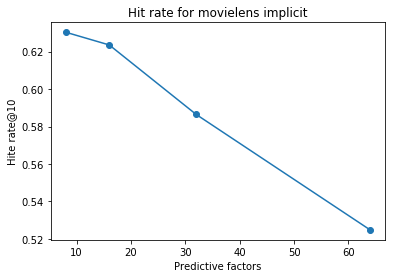

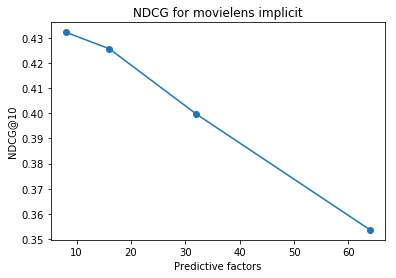

In [2]:
import matplotlib.pyplot as plt


x = ['Predictive factors', 8, 16, 32, 64]
mov_im_y_hit_rate = ['Hit rate for movielens implicit',0.630298013245, 0.623509933775, 0.58642384106, 0.524834437086]
mov_im_y_ndcg = ['NDCG for movielens implicit', 0.432218543046, 0.425662251656, 0.399718543046, 0.353658940397]
mov_ex_rmse = ['RMSE for movielens explicit', 0.958122723092,  0.998417540636, 1.04732251269, 1.05371983829]
mov_ex_ndcg = ['NDCG for movielens explicit', 0.918034082103, 0.91405173195, 0.909892014357, 0.907810540243]
yelp_ex_rmse = ['RMSE for yelp explicit',1.45666159234, 1.44289487231, 1.39886697338, 1.36196578909]
yelp_ex_ndcg = ['NDCG for yelp explicit',0.874890296728,  0.873076786356,0.873724280928, 0.873415378635]
yelp_p2v_rmse = ['RMSE for paragraph2vec yelp expilcit', 1.4503164336, 1.36808351348,  1.30106632369, 1.26638387938]
yelp_p2v_ndcg = ['NDCG for paragraph2vec yelp expilcit', 0.859117181856,  0.862221646954, 0.867300569239, 0.867480505669]


plt.figure(1)
plt.title(mov_im_y_hit_rate[0])
plt.xlabel(x[0])
plt.ylabel('Hite rate@10')
plt.plot(x[1:],mov_im_y_hit_rate[1:] , '-o')
plt.show()

plt.figure(2) 
plt.title(mov_im_y_ndcg[0])
plt.xlabel(x[0])
plt.ylabel('NDCG@10')
plt.plot(x[1:],mov_im_y_ndcg[1:] , '-o')
plt.show()


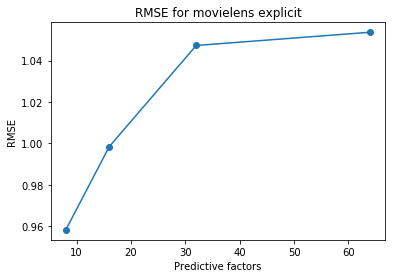

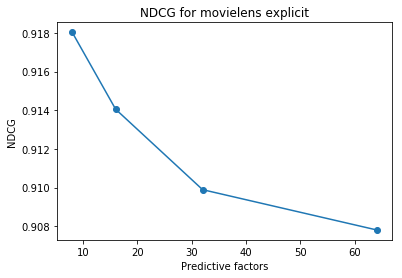

In [3]:
plt.figure(3) 
plt.title(mov_ex_rmse[0])
plt.xlabel(x[0])
plt.ylabel('RMSE')
plt.plot(x[1:],mov_ex_rmse[1:] , '-o')
plt.show()

plt.figure(4) 
plt.title(mov_ex_ndcg[0])
plt.xlabel(x[0])
plt.ylabel('NDCG')
plt.plot(x[1:],mov_ex_ndcg[1:] , '-o')
plt.show()


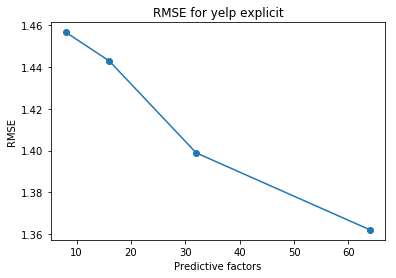

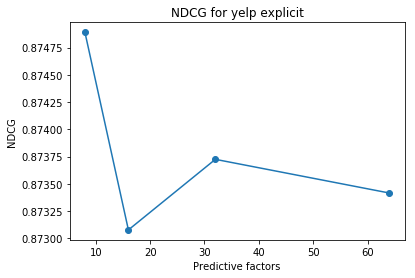

In [4]:
plt.figure(5) 
plt.title(yelp_ex_rmse[0])
plt.xlabel(x[0])
plt.ylabel('RMSE')
plt.plot(x[1:],yelp_ex_rmse[1:] , '-o')
plt.show()


plt.figure(6) 
plt.title(yelp_ex_ndcg[0])
plt.xlabel(x[0])
plt.ylabel('NDCG')
plt.plot(x[1:],yelp_ex_ndcg[1:] , '-o')
plt.show()



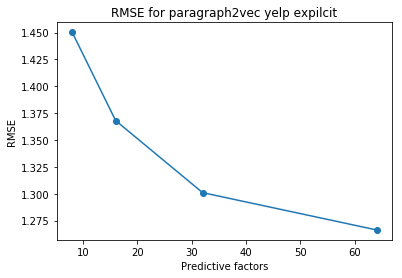

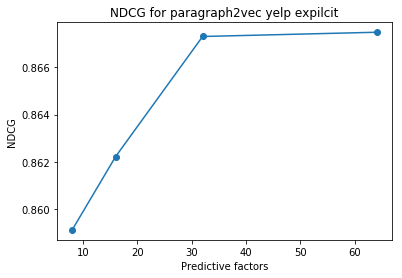

In [5]:

plt.figure(7) 
plt.title(yelp_p2v_rmse[0])
plt.xlabel(x[0])
plt.ylabel('RMSE')
plt.plot(x[1:],yelp_p2v_rmse[1:] , '-o')
plt.show()

plt.figure(8) 
plt.title(yelp_p2v_ndcg[0])
plt.xlabel(x[0])
plt.ylabel('NDCG')
plt.plot(x[1:],yelp_p2v_ndcg[1:] , '-o')
plt.show()

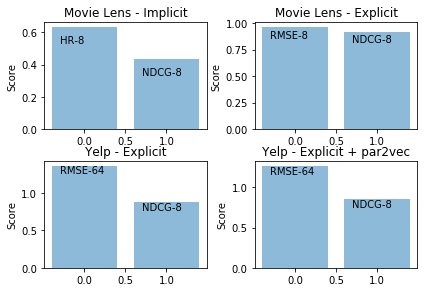

In [8]:
import numpy as np

mov_imp_y_hit_rate_best = np.max(mov_im_y_hit_rate[1:len(mov_im_y_hit_rate)])
mov_imp_y_hit_rate_best_factors = x[np.argmax(mov_im_y_hit_rate[1:len(mov_im_y_hit_rate)])+1]

mov_im_y_ndcg_best = np.max(mov_im_y_ndcg[1:len(mov_im_y_ndcg)])
mov_im_y_ndcg_best_factors = x[np.argmax(mov_im_y_ndcg[1:len(mov_im_y_ndcg)])+1]

mov_ex_rmse_best = np.min(mov_ex_rmse[1:len(mov_ex_rmse)])
mov_ex_rmse_best_factors = x[np.argmin(mov_ex_rmse[1:len(mov_ex_rmse)])+1]

mov_ex_ndcg_best = np.max(mov_ex_ndcg[1:len(mov_ex_ndcg)])
mov_ex_ndcg_best_factors = x[np.argmax(mov_ex_ndcg[1:len(mov_ex_ndcg)])+1]

yelp_ex_rmse_best = np.min(yelp_ex_rmse[1:len(yelp_ex_rmse)])
yelp_ex_rmse_best_factors = x[np.argmin(yelp_ex_rmse[1:len(yelp_ex_rmse)])+1]

yelp_ex_ndcg_best = np.max(yelp_ex_ndcg[1:len(yelp_ex_ndcg)])
yelp_ex_ndcg_best_factors = x[np.argmax(yelp_ex_ndcg[1:len(yelp_ex_ndcg)])+1]

yelp_p2v_rmse_best = np.min(yelp_p2v_rmse[1:len(yelp_p2v_rmse)])
yelp_p2v_rmse_best_factors = x[np.argmin(yelp_p2v_rmse[1:len(yelp_p2v_rmse)])+1]

yelp_p2v_ndcg_best = np.min(yelp_p2v_ndcg[1:len(yelp_p2v_ndcg)])
yelp_p2v_ndcg_best_factors = x[np.argmin(yelp_p2v_ndcg[1:len(yelp_p2v_ndcg)])+1]


f, axarr = plt.subplots(2, 2)
f.tight_layout()
objects = ('Hit-Rate / Factors='+str(mov_imp_y_hit_rate_best_factors), 'NDCG / Factors='+str(mov_im_y_ndcg_best_factors))
y_pos = np.arange(len(objects))
performance = [mov_imp_y_hit_rate_best, mov_im_y_ndcg_best]
axarr[0, 0].annotate('HR-'+str(mov_imp_y_hit_rate_best_factors), xy=(0, 0), xytext=(-0.3, mov_imp_y_hit_rate_best-0.1))
axarr[0, 0].annotate('NDCG-'+str(mov_im_y_ndcg_best_factors), xy=(0, 0), xytext=(0.7, mov_im_y_ndcg_best-0.1))
axarr[0, 0].bar(y_pos, performance, align='center', alpha=0.5)
axarr[0, 0].set_xticks(y_pos, objects)
axarr[0, 0].set_ylabel('Score')
axarr[0, 0].set_title('Movie Lens - Implicit')


objects = ('RMSE / Factors='+str(mov_ex_rmse_best_factors), 'NDCG / Factors='+str(mov_ex_ndcg_best_factors))
y_pos = np.arange(len(objects))
performance = [mov_ex_rmse_best, mov_ex_ndcg_best]
axarr[0, 1].annotate('RMSE-'+str(mov_ex_rmse_best_factors), xy=(0, 0), xytext=(-0.3, mov_ex_rmse_best-0.1))
axarr[0, 1].annotate('NDCG-'+str(mov_ex_ndcg_best_factors), xy=(0, 0), xytext=(0.7, mov_ex_ndcg_best-0.1))
axarr[0, 1].bar(y_pos, performance, align='center', alpha=0.5)
axarr[0, 1].set_xticks(y_pos, objects)
axarr[0, 1].set_ylabel('Score')
axarr[0, 1].set_title('Movie Lens - Explicit')



objects = ('RMSE / Factors='+str(yelp_ex_rmse_best_factors), 'NDCG / Factors='+str(yelp_ex_ndcg_best_factors))
y_pos = np.arange(len(objects))
performance = [yelp_ex_rmse_best, yelp_ex_ndcg_best]
axarr[1, 0].annotate('RMSE-'+str(yelp_ex_rmse_best_factors), xy=(0, 0), xytext=(-0.3, yelp_ex_rmse_best-0.1))
axarr[1, 0].annotate('NDCG-'+str(yelp_ex_ndcg_best_factors), xy=(0, 0), xytext=(0.7, yelp_ex_ndcg_best-0.1))
axarr[1, 0].bar(y_pos, performance, align='center', alpha=0.5)
axarr[1, 0].set_xticks(y_pos, objects)
axarr[1, 0].set_ylabel('Score')
axarr[1, 0].set_title('Yelp - Explicit')


objects = ('RMSE / Factors='+str(yelp_p2v_rmse_best_factors), 'NDCG / Factors='+str(yelp_p2v_rmse_best_factors))
y_pos = np.arange(len(objects))
performance = [yelp_p2v_rmse_best, yelp_p2v_ndcg_best]
axarr[1, 1].annotate('RMSE-'+str(yelp_p2v_rmse_best_factors), xy=(0, 0), xytext=(-0.3, yelp_p2v_rmse_best-0.1))
axarr[1, 1].annotate('NDCG-'+str(yelp_p2v_ndcg_best_factors), xy=(0, 0), xytext=(0.7, yelp_p2v_ndcg_best-0.1))
axarr[1, 1].bar(y_pos, performance, align='center', alpha=0.5)
axarr[1, 1].set_xticks(y_pos, objects)
axarr[1, 1].set_ylabel('Score')
axarr[1, 1].set_title('Yelp - Explicit + par2vec')
plt.show()


For each evaluation metric, we have taken the best scores 
obtained from evaluating the model with different predicting 
factors. This gives us an idea of the performance for each 
approach in its best case scenario

For the Movie Lens database if we consider the NDCG metric,
we can see that including explicit information as the movie
rankings per user, it actually improves the accuracy of the model.
Also, we can see for the RMSE that we are just about less than 1 
star of difference from the actual rankings.

For the Yelp database, we can see that including more 
explicit information as the reviews per user-item, it actually
improves the accuracy of the model. We can also see that the RMSE 
has decreased from about 1.4 to about 1.3. So now, our rankings are
more accurate. We can also see an increment in the NDCG metric for the explicit approach with reviews, wich also confirms the improvement.


In [10]:
import operator


NDCG_IDEAL_SCORES = np.arange(1,0,-0.1)

def hit_rate(sorted_predictions, target):
    movies = [int(i[0]) for i in sorted_predictions]
    if target in movies:
        return True

def ndcg(sorted_predictions, target):
    #each element in sorted prediction, position [0] == movie, [1] == prediction
    
    #Get the index from the champion list
    movies = [int(i[0]) for i in sorted_predictions]
    score = 0
    
    if target in movies:
        #Get its score relative to its position
        score = NDCG_IDEAL_SCORES[movies.index(target)]
        
    return score


def evaluate_integer_input(fname, model, metric, interactions_matrix):
    target_movies = []
    int_matrix = np.load(interactions_matrix)
    int_matrix = np.delete(int_matrix, 0, 0)
    int_matrix = np.delete(int_matrix,0,1)
    lines = np.load(fname)
    for line in lines:
        target_movies.append(line[1])
    summation = 0
    for idx, user in enumerate(int_matrix):
        # pick 100 random non-interacted movies
        zero_indices = np.where(user == 0)[0]
        np.random.shuffle(zero_indices)
        random_indices = zero_indices[0:100]
        # transform into inputs for keras
        movie_vectors = np.append(random_indices, target_movies[idx])
        user_vectors = np.repeat([idx + 1], movie_vectors.size, axis=0)
        # generate predictions
        predictions = model.predict({'user_input': np.array(user_vectors), 'item_input': np.array(movie_vectors)})
        predictions_idx = dict(zip(movie_vectors, predictions))
        sorted_predictions = sorted(predictions_idx.items(), key=operator.itemgetter(1), reverse= True)[0:10]
        if metric == 'hit_rate':
            if hit_rate(sorted_predictions, target_movies[idx]):
                summation += 1
        elif metric == 'ndcg':
            summation += ndcg(sorted_predictions, target_movies[idx])
        else:
            raise StandardError('metric has to be "hit_rate" or "ndcg"')
    return summation/float(int_matrix.shape[0])


In [36]:
hit_rate_accuracy = evaluate_integer_input('movie_lens_implict/input/testing_data.npy', model, 'hit_rate', 'movie_lens_implict/input/int_mat.npy')
print('accuracy rate of: ' + str(hit_rate_accuracy))
ndcg = hit_rate_accuracy = evaluate_integer_input('movie_lens_implict/input/testing_data.npy', model, 'ndcg', 'movie_lens_implict/input/int_mat.npy')
print('NDCG of: ' + str(ndcg))


accuracy rate of: 0.483940397351
NDCG of: 0.318079470199


<b>Conclusion and Next Steps</b>

In this work, we explored the neural network architecture for collaborative filtering and doc2vec. We used three independent models: GMF, MLP and doc2vec.  In order to implement these models, we learned how to use Keras, Tensorflow, and Gensim.  One unexpected thing we learned was on the devops side of things: the importance of properly setting up a development environment.  The models we worked with initially required upwards of two minutes per epoch, it was only after utilizing GPU-acceleration on two servers that we were able to bring the runtime of each epoch to less than 30 seconds, and have manageable development cycles.  Sharing these resources via jupyterhub required us to learn a lot of networking information, such as dynamic DNS, as well as wrangling with firewalls and ports. 

In class, we learned the user-item collaborative filtering which utilizes the relation between users and items. Latent-factor model was also taught, which was an augmented user-item collaborative filtering. It uses the inner-product to estimate the ratings, but only reflects the linear relations. If the relationship is nonlinear, this method simply cannot properly capture the relationship. 

We also learned about word embeddings, which led us to learn about paragraph vectors.  Lastly, the ensemble technique utilized by the winners of the Netflix challenge was clearly demonstrated in practice, as the original model we replicated was really an ensemble of two models, and our contribution was simply a third internal model.  

One key aspect that we learned in class that could be used to further develop the model is utilizing the temporal aspect of the data.  Restaurants and movies rise and fall in popularity, if we were able to capture and model a surge of positive reviews, for example caused by new management, then we’d be able to further improve the accuracy of our recommendation system.  

For additional future work, we open the floor to tuning the parameters of the model, for example, the improvements we saw when using elu instead of relu for activation.  It’s very likely that spending additional time fine-tuning the model will uncover additional improvements.  Each layer of the neural network has a wide variety of potential tuning choices, for example regularization or dropout.  In the timespan of the project, we were unable to explore all options.

<b>References</b>

[1] He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international world wide web conference. 2017.

[2] Salakhutdinov, Ruslan, Andriy Mnih, and Geoffrey Hinton. "Restricted Boltzmann machines for collaborative filtering." Proceedings of the 24th international conference on Machine learning. ACM, 2007.

[3] Sedhain, Suvash, et al. "Autorec: Autoencoders meet collaborative filtering." Proceedings of the 24th International Conference on World Wide Web. ACM, 2015.

[4] Wu, Yao, et al. "Collaborative denoising auto-encoders for top-n recommender systems." Proceedings of the Ninth ACM International Conference on Web Search and Data Mining. ACM, 2016.

[5] Le, Quoc, and Tomas Mikolov. "Distributed representations of sentences and documents." Proceedings of the 31st International Conference on Machine Learning (ICML-14). 2014.

[6] F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History
and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4,
Article 19 (December 2015), 19 pages. DOI=http://dx.doi.org/10.1145/2827872

[7] Nair, Vinod, and Geoffrey E. Hinton. "Rectified linear units improve restricted boltzmann machines." Proceedings of the 27th international conference on machine learning (ICML-10). 2010.

[8] Clevert, Djork-Arné, Thomas Unterthiner, and Sepp Hochreiter. "Fast and accurate deep network learning by exponential linear units (elus)." arXiv preprint arXiv:1511.07289 (2015).

